In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Correct path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/kvasir8K.zip'

# Destination path where you want to unzip the file
dest_path = '/content/Kvasir_folder8k'

# Create destination directory if it doesn't exist
os.makedirs(dest_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_path)

print("Unzipping completed!")

Unzipping completed!


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, callbacks
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt


#from tensorflow.keras import layers, models, optimizers, callbacks

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 244
CHANNELS=3
EPOCHS=60

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Kvasir_folder8k/kvasir-dataset-v2",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8000 files belonging to 8 classes.


In [ ]:
class_names = dataset.class_names
class_names

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

**Function to Split Dataset**

Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model**

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

input_shape = (BATCH_SIZE, 720, 576, CHANNELS)
n_classes = 8

In [ ]:
n_classes = 8

# Mean Normalization Code

In [ ]:
# Function to compute mean and stddev of dataset
def compute_mean_and_variance(dataset):
    mean = np.zeros((IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    variance = np.zeros((IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    count = 0

    for images, _ in dataset:
        mean += np.sum(images.numpy(), axis=0)
        count += images.shape[0]

    mean /= count

    for images, _ in dataset:
        variance += np.sum((images.numpy() - mean) ** 2, axis=0)

    variance /= count

    return mean, np.sqrt(variance)

In [ ]:
import numpy as np
# Compute mean and stddev
mean, stddev = compute_mean_and_variance(dataset)

# Convert mean and stddev to float32
mean = mean.astype(np.float32)
stddev = stddev.astype(np.float32)

In [ ]:
mean

array([[[5.231979 , 5.905262 , 4.423993 ],
        [5.5340657, 6.13283  , 4.896904 ],
        [5.613609 , 6.1335607, 5.020712 ],
        ...,
        [5.267943 , 6.011409 , 4.4774323],
        [5.2241173, 5.967904 , 4.5688434],
        [4.900234 , 5.496801 , 4.3540487]],

       [[5.2217536, 5.8476863, 4.584449 ],
        [5.4934983, 6.0843883, 4.8477   ],
        [5.6065016, 6.140021 , 4.9699316],
        ...,
        [5.3223534, 5.9895644, 4.7470875],
        [5.175769 , 5.8912206, 4.5395956],
        [4.840741 , 5.4705143, 4.2769747]],

       [[5.163296 , 5.662206 , 4.5178156],
        [5.415615 , 5.904908 , 4.76487  ],
        [5.543131 , 5.9570594, 4.9427867],
        ...,
        [5.326115 , 5.852255 , 4.7665954],
        [5.1808553, 5.78416  , 4.5032525],
        [4.7638674, 5.2940226, 4.249976 ]],

       ...,

       [[3.8217342, 4.2294793, 3.6328132],
        [3.941928 , 4.331688 , 3.73636  ],
        [4.015237 , 4.348424 , 3.8191311],
        ...,
        [4.039244 , 4.3728

In [ ]:
stddev

array([[[ 9.267272 ,  7.330635 ,  7.7798758],
        [ 9.07615  ,  7.280912 ,  7.7351627],
        [ 9.152675 ,  7.445207 ,  7.758405 ],
        ...,
        [10.192571 ,  8.47042  ,  8.841779 ],
        [ 9.614388 ,  8.093792 ,  8.483722 ],
        [ 9.766237 ,  8.158346 ,  8.580366 ]],

       [[ 9.2293   ,  7.2693605,  7.676703 ],
        [ 9.097984 ,  7.2837915,  7.7284102],
        [ 9.137722 ,  7.3317075,  7.744369 ],
        ...,
        [10.401555 ,  8.60958  ,  8.955111 ],
        [ 9.784656 ,  8.19912  ,  8.603996 ],
        [ 9.780446 ,  8.187813 ,  8.625308 ]],

       [[ 9.226634 ,  7.2665405,  7.7073765],
        [ 9.079474 ,  7.282718 ,  7.660656 ],
        [ 9.379036 ,  7.4171996,  7.8497853],
        ...,
        [10.895799 ,  8.988109 ,  9.260192 ],
        [10.337885 ,  8.608937 ,  9.007985 ],
        [ 9.798213 ,  8.24635  ,  8.5781   ]],

       ...,

       [[10.408024 ,  8.78113  ,  8.874009 ],
        [10.265908 ,  8.732486 ,  8.819702 ],
        [10.905437 ,  

# Mean Filter Code



In [ ]:
@tf.keras.utils.register_keras_serializable()
class MeanFilterLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(MeanFilterLayer, self).__init__(**kwargs)
        self.filter = tf.constant(1.0 / 9.0, shape=[3, 3, CHANNELS, 1], dtype=tf.float32)

    def call(self, inputs):
        return tf.nn.depthwise_conv2d(inputs, self.filter, strides=[1, 1, 1, 1], padding='SAME')

# Custom Normalization Layer
@tf.keras.utils.register_keras_serializable()
class CustomNormalizationLayer(layers.Layer):
    def __init__(self, mean, stddev, **kwargs):
        super(CustomNormalizationLayer, self).__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs):
        return (inputs - self.mean) / self.stddev

# Define the preprocessing pipeline
def preprocessing_pipeline(mean, stddev):
    return tf.keras.Sequential([
        #layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        #layers.Rescaling(1./255),
        MeanFilterLayer(),
        CustomNormalizationLayer(mean, stddev)
])

# Model Architecture

In [ ]:
# Custom Residual Block Layer
class ResidualBlock(layers.Layer):
    def __init__(self, filters, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()

        if stride != 1 or filters != 64:
            self.shortcut = models.Sequential([
                layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same'),
                layers.BatchNormalization()
            ])
        else:
            self.shortcut = lambda x: x

    def call(self, inputs, training=False):
        shortcut = self.shortcut(inputs)
        x = self.conv1(inputs, training=training)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.conv2(x, training=training)
        x = self.bn2(x, training=training)
        x = layers.Add()([x, shortcut])
        x = self.relu(x)
        return x

# Define the model
def create_resnet50(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Resize, rescale, and augment data
    x = resize_and_rescale(inputs)
    x = data_augmentation(x)

    x = preprocessing_pipeline(mean, stddev)(inputs)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)
    x = ResidualBlock(128, stride=2)(x)
    x = ResidualBlock(128)(x)
    x = ResidualBlock(256, stride=2)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(512, stride=2)(x)
    x = ResidualBlock(512)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Create ResNet-50 model
resnet50_model = create_resnet50((IMAGE_SIZE, IMAGE_SIZE, CHANNELS), n_classes)

# Display model summary
resnet50_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 122, 122, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 122, 122, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ (None, 61, 61, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_1 (ResidualBlock)     │ (None, 61, 61, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_2 (ResidualBlock)     │ (None, 31, 31, 128)         │         231,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_3 (ResidualBlock)     │ (None, 31, 31, 128)         │         313,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_4 (ResidualBlock)     │ (None, 16, 16, 256)         │         921,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_5 (ResidualBlock)     │ (None, 16, 16, 256)         │       1,249,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_6 (ResidualBlock)     │ (None, 8, 8, 512)           │       3,677,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_7 (ResidualBlock)     │ (None, 8, 8, 512)           │       4,988,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,572,808 (44.15 MB)

 Trainable params: 11,561,416 (44.10 MB)

 Non-trainable params: 11,392 (44.50 KB)

In [ ]:
resnet50_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Add learning rate scheduler and early stopping callbacks
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [ ]:
history = resnet50_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=70,
    callbacks=[lr_scheduler, early_stopping],
)

Epoch 1/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 88s 217ms/step - accuracy: 0.4844 - loss: 1.2768 - val_accuracy: 0.4762 - val_loss: 1.4248 - learning_rate: 0.0010
Epoch 2/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - accuracy: 0.5923 - loss: 0.8807 - val_accuracy: 0.2113 - val_loss: 17.0184 - learning_rate: 0.0010
Epoch 3/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - accuracy: 0.6049 - loss: 0.8250 - val_accuracy: 0.6000 - val_loss: 0.8514 - learning_rate: 0.0010
Epoch 4/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - accuracy: 0.6534 - loss: 0.7552 - val_accuracy: 0.6450 - val_loss: 0.6725 - learning_rate: 0.0010
Epoch 5/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 132ms/step - accuracy: 0.6600 - loss: 0.7041 - val_accuracy: 0.6612 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 6/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 131ms/step - accuracy: 0.6669 - loss: 0.6878 - val_accuracy: 0.6725 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 7/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 130ms/step - accuracy: 0.

Graphs & Results

In [ ]:
scores = resnet50_model.evaluate(test_ds)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8886 - loss: 0.2500


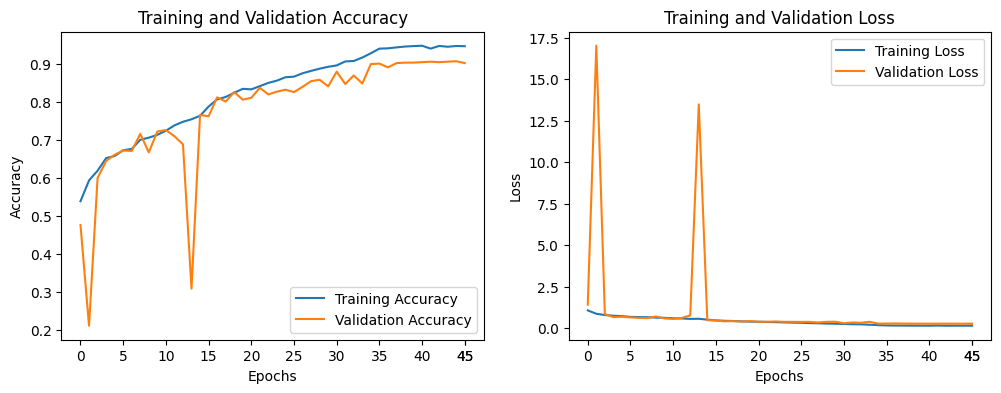

In [ ]:
# Use the length of the actual data (acc and val_acc arrays) for the x-axis
epochs_range = range(len(acc))  # or len(val_acc), they should have the same length

plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(ticks=list(range(0, len(acc), 5)) + [len(acc)-1])  # Add the last epoch to x-axis ticks

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(ticks=list(range(0, len(loss), 5)) + [len(loss)-1])  # Add the last epoch to x-axis ticks

plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


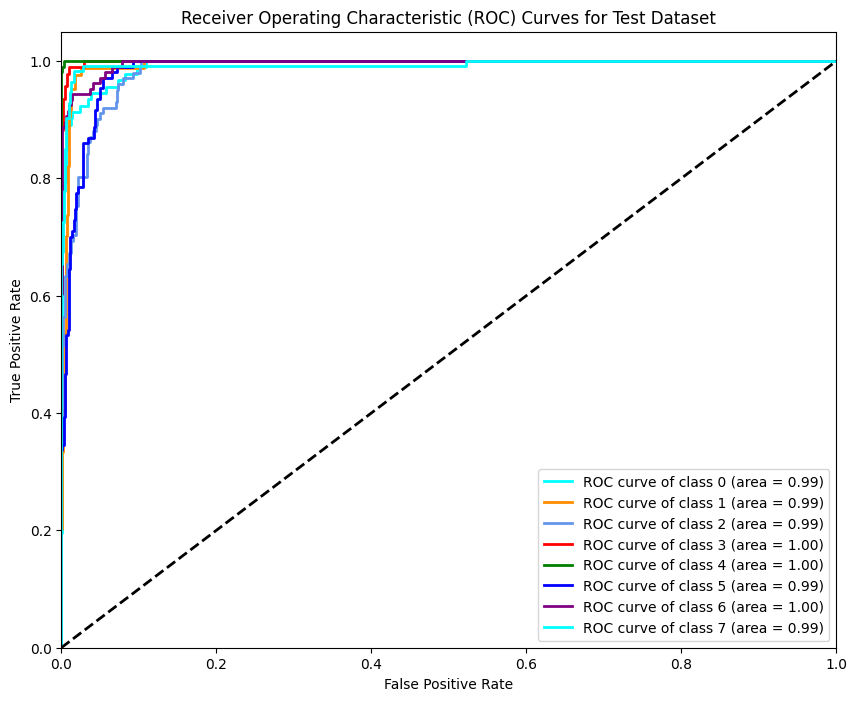

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from itertools import cycle
import tensorflow as tf

# Assuming test_ds, googlenet_model, and class_names are already defined
n_classes = len(class_names)

# Accumulate all batches into numpy arrays
all_images = []
all_labels = []

for images_batch, labels_batch in test_ds:
    all_images.append(images_batch.numpy())
    all_labels.append(labels_batch.numpy())

# Convert lists to numpy arrays
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Get model predictions
test_predictions = resnet50_model.predict(all_images)

# One-hot encode the labels if they are not already
if all_labels.ndim == 1 or all_labels.shape[1] != n_classes:
    all_labels = tf.keras.utils.to_categorical(all_labels, num_classes=n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), test_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'purple', 'cyan'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Test Dataset')
plt.legend(loc="lower right")
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x800 with 0 Axes>

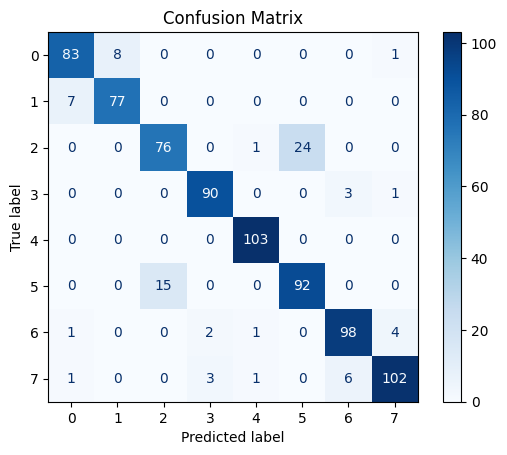

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        92
           1       0.91      0.92      0.91        84
           2       0.84      0.75      0.79       101
           3       0.95      0.96      0.95        94
           4       0.97      1.00      0.99       103
           5       0.79      0.86      0.83       107
           6       0.92      0.92      0.92       106
           7       0.94      0.90      0.92       113

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Assuming you have already defined your test_ds and googlenet_model

all_true_labels = []
all_predicted_labels = []

for images_batch, labels_batch in test_ds:
    # Get true labels
    true_labels = labels_batch.numpy()
    all_true_labels.extend(true_labels)

    # Get predicted labels
    batch_predictions = resnet50_model.predict(images_batch)
    predicted_labels = np.argmax(batch_predictions, axis=1)
    all_predicted_labels.extend(predicted_labels)

# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=np.arange(8))  # Use np.arange(8) to display 0 to 7

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(all_true_labels, all_predicted_labels, target_names=[str(i) for i in range(8)])
print("Classification Report:\n", report)

In [ ]:
resnet50_model.save('/content/drive/My Drive/resnet50_model92.h5')

NotImplementedError: 
Object CustomNormalizationLayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the object must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [ ]:
class MeanFilterLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(MeanFilterLayer, self).__init__(**kwargs)
        self.filter = tf.constant(1.0 / 9.0, shape=[3, 3, CHANNELS, 1], dtype=tf.float32)

    def call(self, inputs):
        return tf.nn.depthwise_conv2d(inputs, self.filter, strides=[1, 1, 1, 1], padding='SAME')

    def get_config(self):
        config = super().get_config()
        config.update({
            'filter': self.filter.numpy().tolist()  # Convert the filter to a list
        })
        return config

class CustomNormalizationLayer(tf.keras.layers.Layer):
    def __init__(self, mean, std, **kwargs):
        super(CustomNormalizationLayer, self).__init__(**kwargs)
        self.mean = mean
        self.std = std

    def call(self, inputs):
        return (inputs - self.mean) / self.std

    def get_config(self):
        config = super().get_config()
        config.update({
            "mean": self.mean.tolist(),  # Convert to list for serialization
            "std": self.std.tolist()   # Convert to list for serialization
        })
        return config